In [1]:
#quickstart
from pathlib import Path
import pandas as pd
from bids import BIDSLayout
from joblib import Parallel, delayed
import nilearn
import nibabel as nib
import nltools.prefs as prf
from nilearn import datasets, image, plotting, input_data
from nilearn.masking import apply_mask
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, index_img
import numpy as np
import matplotlib.pylab as plt

import rpy2
from rpy2.robjects.packages import importr
from pymer4 import Lmer
psych = importr('psych')


import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

import os
import glob
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from nltools.stats import fdr, one_sample_permutation
from copy import deepcopy
from nltools.utils import get_anatomical
import nltools.plotting as nlplt
from datetime import date
from joblib import Parallel, delayed

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from nilearn.input_data import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

#dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/dat_paths_11272019.csv') 
#atlas = image.load_img('/data/MBDU/midla/notebooks/campcc/hox_msdl_atlas.nii.gz')
#sub1 = image.load_img('/data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm/sub-20900/out/fmrip

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
dat_paths = pd.read_csv('/data/MBDU/midla/notebooks/campcc/dat_paths_rest.csv')
dat_paths

confounds_path                                                                                                                                                                                                     image_path                                                                                                                                                                mask_path  run                                                                                                                                                                                                  scaled_path  session  subject  task
0    /data/MBDU/midla/data/derivatives/fitlins/rest_dm_only/sub-20900/ses-01/run-1/out/out/fitlins/sub-20900/ses-01/sub-20900_ses-01_task-rest_run-1_design.tsv  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-20900/out/fmriprep/sub-20900/anat/sub-20900_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz    1  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-20900/out/fmriprep/sub-20900/ses-01/func/sub-20900_ses-01_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz        1    20900  rest
1    /data/MBDU/midla/data/derivatives/fitlins/rest_dm_only/sub-20900/ses-04/run-1/out/out/fitlins/sub-20900/ses-04/sub-20900_ses-04_task-rest_run-1_design.tsv  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-20900/out/fmriprep/sub-20900/ses-04/func/sub-20900_ses-04_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-20900/out/fmriprep/sub-20900/anat/sub-20900_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz    1  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-20900/out/fmriprep/sub-20900/ses-04/func/sub-20900_ses-04_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz        4    20900  rest
2    /data/MBDU/midla/data/derivatives/fitlins/rest_dm_only/sub-21111/ses-01/run-1/out/out/fitlins/sub-21111/ses-01/sub-21111_ses-01_task-rest_run-1_design.tsv  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-21111/out/fmriprep/sub-21111/ses-01/func/sub-21111_ses-01_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-21111/out/fmriprep/sub-21111/anat/sub-21111_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz    1  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-21111/out/fmriprep/sub-21111/ses-01/func/sub-21111_ses-01_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz        1    21111  rest
3    /data/MBDU/midla/data/derivatives/fitlins/rest_dm_only/sub-21669/ses-01/run-1/out/out/fitlins/sub-21669/ses-01/sub-21669_ses-01_task-rest_run-1_design.tsv  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-21669/out/fmriprep/sub-21669/ses-01/func/sub-21669_ses-01_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-21669/out/fmriprep/sub-21669/anat/sub-21669_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz    1  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-21669/out/fmriprep/sub-21669/ses-01/func/sub-21669_ses-01_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz        1    21669  rest
4    /data/MBDU/midla/data/derivatives/fitlins/rest_dm_only/sub-21723/ses-01/run-1/out/out/fitlins/sub-21723/ses-01/sub-21723_ses-01_task-rest_run-1_design.tsv  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-21723/out/fmriprep/sub-21723/ses-01/func/sub-21723_ses-01_ta

In [12]:
cfds

t_comp_cor_00  t_comp_cor_01  t_comp_cor_02  t_comp_cor_03  t_comp_cor_04  t_comp_cor_05  aroma_motion_01  aroma_motion_02  aroma_motion_03  aroma_motion_04  aroma_motion_05  aroma_motion_07  aroma_motion_10  aroma_motion_11  aroma_motion_12  aroma_motion_13  aroma_motion_14  aroma_motion_17  aroma_motion_18  aroma_motion_21  aroma_motion_28  aroma_motion_33  aroma_motion_34  aroma_motion_36  aroma_motion_38  aroma_motion_43  aroma_motion_46  aroma_motion_47  aroma_motion_52  aroma_motion_53  aroma_motion_55  aroma_motion_56  aroma_motion_57  aroma_motion_60  aroma_motion_62  cosine00  cosine01  cosine02  cosine03  cosine04  cosine05  censor_000  censor_001  censor_002  censor_003       trans_x  trans_x_derivative1  trans_x_power2  trans_x_derivative1_power2   trans_y  trans_y_derivative1  trans_y_power2  trans_y_derivative1_power2       trans_z  trans_z_derivative1  trans_z_derivative1_power2  trans_z_power2     rot_x  rot_x_derivative1  rot_x_derivative1_power2  rot_x_power2  \
0         0.000000       0.000000       0.000000       0.000000       0.000000       0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000           1           0           0           0  1.319450e-08             0.000000    1.740948e-16                0.000000e+00 -0.006812             0.000000    4.639776e-05                0.000000e+00  1.316630e-08             0.000000                0.000000e+00    1.733515e-16  0.000000           0.000000              0.000000e+00  0.000000e+00   
1         0.000000       0.000000       0.000000       0.000000       0.000000       0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000           0           1           0           0  9.616670e-03             0.009617    9.248034e-05                9.248009e-05  0.111363             0.118175    1.240172e-02                1.396523e-02  2.543030e-01             0.254303                6.467001e-02    6.467002e-02  0.001246           0.001246              1.551594e-06  1.551594e-06   
2         0.000000       0.000000       0.000000       0.000000       0.000000       0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000           0           0           1           0  7.359130e-03            -0.002258    5.415679e-05                5.096487e-06  0.115530             0.004167    1.334718e-02                1.736389e-05  2.397440e-01            -0.014559                2.119645e-04    5.747719e-02  0.000624          -0.000622              3.864462e-07  3.893535e-07   
3    

In [3]:
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')
basc64 = basc['scale064']
atlas = image.load_img(basc64)

In [4]:
atlas_dat = atlas.get_fdata()
uvs = np.unique(atlas_dat)
atlas_in_4d = []
for uv in uvs:
    atlas_in_4d.append((atlas_dat == uv).astype(int))
atlas_4d_dat = np.array(atlas_in_4d)

In [5]:
for _,row in dat_paths.iterrows():
    break
    
img = image.load_img(row.scaled_path)
regions_extracted_img = image.new_img_like(img,atlas_4d_dat,copy_header=False)
regions_extracted_img = resample_to_img(regions_extracted_img,img)

/gpfs/gsfs11/users/MBDU/midla/env/lib/python3.7/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int64 to float64
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [17]:
included_subjects = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/included_subjects.csv',index_col = 0)
dat_paths = dat_paths[dat_paths['subject'].isin(included_subjects['SDAN'])]
dat_paths = dat_paths.loc[dat_paths[dat_paths.columns[4:6]].duplicated(keep='last') == False]

In [24]:
single_ses_subs = dat_paths.loc[dat_paths.session.astype(int) <= 4, :].groupby('subject').session.nunique().reset_index().query('session <= 2').subject
dat_ind = ~dat_paths.subject.isin(single_ses_subs) & (dat_paths.session.astype(int) <= 4)
dat_paths = dat_paths.loc[dat_ind]
dat_paths.reset_index(inplace=True)
dat_paths = dat_paths.drop(columns=['index'])

In [22]:
cfds_physio = []
for _,row in dat_paths.iterrows():
    if (os.path.isfile('/data/MBDU/midla/data/bids/sub-{}/ses-0{}/func/sub-{}_ses-0{}_task-rest_run-{}_physio.tsv.gz'.format(row.subject,row.session,row.subject,row.session,row.run))):
        cfds_physio.append('/data/MBDU/midla/notebooks/campcc/physio/new_cfds_rest/new_cfds_rest_subject_{}_session_{}_run_{}_task_rest.tsv'.format(row.subject,row.session,row.run))
    else:
        cfds_physio.append('')
dat_paths['cfds_physio_path'] = cfds_physio


In [48]:
os.path.isfile('/data/MBDU/midla/data/bids/sub-{}/ses-0{}/func/sub-{}_ses-0{}_task-rest_run-{}_physio.tsv.gz'.format(dat_paths.loc[32].subject,dat_paths.loc[32].session,dat_paths.loc[32].subject,dat_paths.loc[32].session,dat_paths.loc[32].run))

True

In [47]:
dat_paths.loc[32].subject

23660

In [36]:
#dat_paths[dat_paths['cfds_physio_path'] == '']
dat_paths[dat_paths['subject'] == 22293]

level_0                                                                                                                                              confounds_path                                                                                                                                                                                                     image_path                                                                                                                                                                mask_path  run                                                                                                                                                                                                  scaled_path  session  subject  task                                                                                                  cfds_physio_path
3        3  /data/MBDU/midla/data/derivatives/fitlins/rest_dm_only/sub-22293/ses-01/run-1/out/out/fitlins/sub-22293/ses-01/sub-22293_ses-01_task-rest_run-1_design.tsv  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22293/out/fmriprep/sub-22293/ses-01/func/sub-22293_ses-01_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22293/out/fmriprep/sub-22293/anat/sub-22293_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz    1  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22293/out/fmriprep/sub-22293/ses-01/func/sub-22293_ses-01_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz        1    22293  rest  /data/MBDU/midla/notebooks/campcc/physio/new_cfds_rest/new_cfds_rest_subject_22293_session_1_run_1_task_rest.tsv
4        4  /data/MBDU/midla/data/derivatives/fitlins/rest_dm_only/sub-22293/ses-02/run-1/out/out/fitlins/sub-22293/ses-02/sub-22293_ses-02_task-rest_run-1_design.tsv  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22293/out/fmriprep/sub-22293/ses-02/func/sub-22293_ses-02_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22293/out/fmriprep/sub-22293/anat/sub-22293_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz    1  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22293/out/fmriprep/sub-22293/ses-02/func/sub-22293_ses-02_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz        2    22293  rest                                                                                                                  
5        5  /data/MBDU/midla/data/derivatives/fitlins/rest_dm_only/sub-22293/ses-04/run-1/out/out/fitlins/sub-22293/ses-04/sub-22293_ses-04_task-rest_run-1_design.tsv  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22293/out/fmriprep/sub-22293/ses-04/func/sub-22293_ses-04_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22293/out/fmriprep/sub-22293/anat/sub-22293_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz    1  /data/MBDU/midla/data/derivatives/fmriprep/rn_aroma_20190910_2mm_rest/sub-22293/out/fmriprep/sub-22293/ses-04/func/sub-22293_ses-04_task-rest_run-1_echo-2_space-MNI152NLin2009cAsym_desc-scale_bold.nii.gz        4    22293  rest  /data/MBDU/midla/notebooks/campcc/physio/new_cfds_rest/new_cfds_rest_subject_22293_session_4_run_1_task_rest.tsv

In [39]:
dat_paths.to_csv('/data/MBDU/midla/notebooks/campcc/rest_paths_for_icc.csv')

In [9]:
#Function: takes in row and masker object
#Returns image masked by grey matter, confounds, and transformed to atlas masker
def gm_weight_and_mask(row, regions_extracted_img, n_dummy=4, min_trs=100, **kwargs):
    img = image.load_img(row.scaled_path)
    if img.get_fdata().shape[-1] < min_trs:
        return None
    # load subjects grey matter mask
    mask_img = resample_to_img(image.load_img(row.mask_path),img)
    mask_dat = mask_img.get_fdata()[:,:,:,np.newaxis]
    
    # make a binary grey matter mask
    mask_bin = mask_dat > 0
    
    # mask the regions image by the subject grey matter
    regions_masked_dat = regions_extracted_img.get_fdata() * mask_bin
    regions_masked_img = image.new_img_like(regions_extracted_img, 
                                            regions_masked_dat, 
                                            affine=regions_extracted_img.affine, 
                                            copy_header=True)
    
    # create a new masker instance
    masker = input_data.NiftiMapsMasker(
        regions_masked_img, resampling_target="data", **kwargs)
    
    # apply the grey matter mask to the image data
    gm_dat = mask_dat * img.get_fdata()
    gm_img = image.new_img_like(img, gm_dat, affine=img.affine, copy_header=True)
    
    # Load confounds and remove drift columns if present
#     try:
#         cfds = pd.read_csv(row.confounds_path, sep='\t')
#         cfds = cfds.loc[:, cfds.columns.values[~cfds.columns.str.contains('drift')]]
#         return masker.fit_transform(gm_img, cfds.values)[n_dummy:, :]
#    except KeyError:
    
    masked = masker.fit_transform(gm_img)[n_dummy:, :]
    pd.DataFrame(masked).to_csv("/data/MBDU/midla/notebooks/campcc/alt_rs_conn/basc_rest_complex_ts_subject_{}_session_{}_run_{}_task_{}.csv".format(row.subject,row.session,row.run,row.task),header=None, index=None)
    return masked

In [79]:
for _, row in dat_paths.iterrows():
    gm_weight_and_mask(row, detrend=False, memory='nilearn_cache', memory_level=1) 

KeyboardInterrupt: 

In [96]:
subject_ts = Parallel(n_jobs=10, verbose=10)(delayed(gm_weight_and_mask)(row, regions_extracted_img, detrend=False, memory='nilearn_cache', memory_level=1) for _, row in dat_paths.iterrows())

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  5.1min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  6.5min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  7.4min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 10.0min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 11.8min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed: 14.2min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed: 16.2min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed: 18.4min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 21.0min
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed: 23.5min
[Parallel(n_jobs=10)]: Done 143 out of 147 | elapsed: 26.2min remaining:   44.0s
[Parallel(n_jobs=10)]: Done 147 out of 147 | elapsed: 26.9min finished


In [38]:
fnames = []
for _,row in dat_paths.iterrows():
    if os.path.isfile('/data/MBDU/midla/notebooks/campcc/alt_rs_conn/basc_rest_complex_ts_subject_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task)):
        fnames.append('/data/MBDU/midla/notebooks/campcc/alt_rs_conn/basc_rest_complex_ts_subject_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task))
    else:
        fnames.append('')
dat_paths['alt_rs_path'] = fnames

In [9]:
def lr(confounds_path,time_series):
    if(time_series == ''):
        return None
    time_series = pd.read_csv(row.alt_rs_path,header=None).values
    cfd = pd.read_csv(confounds_path, sep='\t')
    #censor_cols = [cc for cc in cfd.columns if 'censor' in cc]
    #cosine_cols = [cc for cc in cfd.columns if 'cosine' in cc]
    #motion = [cc for cc in cfd.columns if 'motion' in cc]
    cols = [cc for cc in cfd.columns if 'comp_cor' not in cc]
    cols = [cc for cc in cols if 'aroma' not in cc]
    censored_time_series = time_series.copy()
    for yi in range(time_series.shape[1]):
        X= cfd.loc[4:, cols]
        y = time_series[:,yi]
        lr = LinearRegression()
        fitted = lr.fit(X,y)
        pred = fitted.predict(X)
        censored_time_series[:,yi] = y-pred
        
    #pd.DataFrame(p).to_csv('/data/MBDU/midla/notebooks/campcc/ppi/pca/pca_{}_session_{}_run_{}_task_{}.csv'.format(row.subject,row.session,row.run,row.task),header = None, index = None)
    return censored_time_series

In [10]:
#dat_paths.reset_index(inplace=True)
rs_ts = []
for _,row in dat_paths.iterrows():
    print(_)
    rs_ts.append(lr(row.cfds_physio_path,row.alt_rs_path))

5
6
7
14
15
16
17
18
19
20
21
22
23
37
38
39
79
80
81
82
84
85
86
87
159
160
161
162
166
167
168
169
176
177
178
179
180
181
182
183
194
195
197
200
201
202
207
208
209
210
211
212
213
214
215
216
217
218
220
221
222
223
226
227
228
229
230
231
232
233
234
235
236
240
241
242
243
244
245
246
247
248
249
250
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
281
282
283
284
288
289
290
291
309
310
311
312
315
316
317


KeyboardInterrupt: 

In [ ]:
rs_ts_copy = rs_ts
for x in range(len(rs_ts)):
    if(type(rs_ts[x]) != type(rs_ts[0])):
        del(rs_ts[x])
        x = x-1

In [44]:
len(correlation_matrices)

241

In [45]:
len(dat_paths)

241

In [ ]:
# First we need to do subjects timeseries signals extraction and then estimating
# correlation matrices on those signals.
# To extract timeseries signals, we call transform() from RegionExtractor object
# onto each subject functional data stored in func_filenames.
# To estimate correlation matrices we import connectome utilities from nilearn
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(rs_ts)
# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of MDD patients are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))
mean_correlation_matrix = correlation_measure.mean_
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=regions_extracted_img)
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

In [46]:
correlation_matrices.shape

(241, 52, 52)

In [ ]:
matrix_ts0 = []
for i in range(correlation_matrices.shape[1]):
    matrix_ts0.append([])
    for j in range(correlation_matrices.shape[2]):
        matrix_ts0[i].append([])
        subject_values = []
        for k in range(correlation_matrices.shape[0]):
            subject_values.append(correlation_matrices[k][i][j])
        matrix_ts0[i][j] = subject_values

In [ ]:
icc_dat = pd.DataFrame()
icc_dat['subject'] = ['']
icc_dat['session'] = ['']

In [ ]:
for i in range(correlation_matrices.shape[1]):
    for j in range(correlation_matrices.shape[2]):
        icc_dat['{}_{}'.format(i,j)] = [0.0]

In [ ]:
dat_paths.reset_index(inplace=True)

In [ ]:
for _,row in dat_paths.iterrows():
    corr = correlation_matrices[_]
    newrow = []
    newrow.append('{}'.format(row.subject))
    newrow.append('{}'.format(row.session))
    for i in range(correlation_matrices.shape[1]):
            for j in range(correlation_matrices.shape[2]):
                newrow.append(corr[i][j])
    icc_dat.loc[_] = newrow
    print('Done {} out of 440'.format(_))

In [73]:
icc_dat

subject session  0_0       0_1       0_2       0_3       0_4       0_5       0_6       0_7       0_8       0_9      0_10      0_11      0_12      0_13      0_14      0_15      0_16      0_17      0_18      0_19      0_20      0_21      0_22      0_23      0_24      0_25      0_26      0_27      0_28      0_29      0_30          0_31      0_32      0_33      0_34      0_35      0_36      0_37      0_38      0_39      0_40      0_41      0_42      0_43      0_44      0_45      0_46      0_47      0_48      0_49      0_50      0_51       1_0  1_1       1_2       1_3       1_4       1_5       1_6       1_7       1_8       1_9      1_10      1_11      1_12      1_13      1_14      1_15      1_16      1_17      1_18      1_19      1_20      1_21      1_22      1_23      1_24      1_25      1_26      1_27      1_28      1_29      1_30      1_31      1_32      1_33      1_34      1_35      1_36      1_37      1_38      1_39      1_40      1_41      1_42      1_43      1_44      1_45  \
0     20900       1  1.0  0.411166  0.491597  0.566222  0.569351  0.646995  0.631105  0.595525  0.472969  0.196559  0.462892  0.426355  0.412706  0.455524  0.180332  0.141470  0.135726  0.071625  0.067053  0.320017  0.304383  0.168847  0.184328  0.216961  0.202187  0.243991  0.251817  0.264876  0.252795  0.151210  0.139437  7.397771e-02  0.094949  0.119232  0.105617  0.296912  0.355719  0.398179  0.449213  0.471750  0.465301  0.487466  0.474268  0.445724  0.470028  0.452261  0.423010  0.331043  0.280864 -0.146501  0.029728 -0.065120  0.411166  1.0  0.961454  0.932791  0.928900  0.847927  0.804639  0.764345  0.599037  0.458869  0.522966  0.506328  0.493302  0.272804  0.157985  0.078004  0.100668  0.242867  0.343604  0.427241  0.389230  0.275963  0.305167  0.305830  0.270463  0.246912  0.269167  0.191752  0.184595  0.137289  0.078962  0.225158  0.168741  0.231358  0.196136  0.219472  0.336463  0.378261  0.385358  0.351330  0.325567  0.339789  0.325948  0.310355  0.247431  0.228702   
1     20900       4  1.0  0.665877  0.646031  0.677387  0.663838  0.618825  0.525140  0.474726  0.332243  0.318386  0.345524  0.320873  0.347127  0.320970  0.182934  0.177175  0.172754  0.355322  0.323392  0.526039  0.524025  0.522875  0.526458  0.524846  0.512782  0.522637  0.523750  0.549284  0.541497  0.403380  0.387318  2.813899e-01  0.246632  0.280290  0.305906  0.495673  0.522141  0.553613  0.608996  0.604422  0.598879  0.593780  0.597915  0.608757  0.611104  0.602889  0.587444  0.567351  0.473053 -0.325652  0.284204 -0.121122  0.665877  1.0  0.962048  0.938249  0.940568  0.912088  0.893351  0.866443  0.721497  0.689200  0.679718  0.673472  0.671738  0.529805  0.413973  0.321117  0.326349  0.371053  0.387180  0.465182  0.443366  0.483806  0.483624  0.510112  0.504513  0.498377  0.507934  0.510321  0.541371  0.476342  0.436319  0.393634  0.319461  0.362433  0.377954  0.508727  0.512334  0.510037  0.522240  0.488415  0.483303  0.496465  0.494782  0.485645  0.485994  0.473987   
4     21748       2  1.0 -0.017787 -0.019104  0.026753  0.026753  0.006551  0.041575  0.049638  0.138050 -0.255940 -0.314434 -0.245584 -0.151176 -0.011782 -0.098249 -0.109232 -0.068233  0.093296  0.125785 -0.070545 -0.164913 -0.070906  0.061147  0.171309  0.199138  0.135072  0.192003  0.177318  0.130593  0.037886  0.060183  2.328082e-02  0.042008  0.105878  0.091445  0.098161  0.025201  0.057517  0.040472  0.026764 -0.053112 -0.190891 -0.194591 -0.193329 -0.178275 -0.214859 -0.221083 -0.195018 -0.204476  0.011477 -0.194375  0.175967 -0.017787  1.0  0.938111  0.934294  0.934294  0.917250  0.856213  0.829129  0.343250  0.114039  0.049383  0.011161  0.049438 -0.231743 -0.063733  0.011019  0.058257  0.042522  0.095783  0.295587  0.318177  0.158164  0.020354 -0.015561  0.030256  0.099476 -0.012951 -0.136999 -0.148423 -0.118223 -0.119300 -0.165356 -0.021310  0.021138 -0.020032 -0.010511  0.060241 -0.052849  0.000988  0.101534  0.142088  0.394682  0.407783  0.361794  0.334347  0.415082   
5     21748     

In [ ]:
measure_iccs=[]
single_ses_subs = icc_dat.loc[icc_dat.session.astype(int) <= 4, :].groupby('subject').session.nunique().reset_index().query('session <= 2').subject
dat_ind = ~icc_dat.subject.isin(single_ses_subs) & (icc_dat.session.astype(int) <= 4)
measure_cols = icc_dat.columns[2:]
for mc in measure_cols:
    psych_dat = icc_dat.loc[dat_ind, ['subject', 'session', mc]].set_index(['subject', 'session']).unstack()
    mc_res = psych.ICC(psych_dat, missing=False,alpha = .05/1352)
    mc_res = mc_res[0].loc[['Single_random_raters', 'Single_fixed_raters']]
    mc_res['measure'] = mc
    measure_iccs.append(mc_res)
    print('Done {} of 2500'.format(len(measure_iccs)))
measure_iccs = pd.concat(measure_iccs)    

In [23]:
measure_df = pd.DataFrame(measure_iccs)
measure_df.to_csv('/data/MBDU/midla/notebooks/campcc/test_retest/resting_state_iccs_complex.csv')

In [2]:
measure_df = pd.read_csv('/data/MBDU/midla/notebooks/campcc/test_retest/resting_state_iccs.csv')

In [24]:
random = measure_df[measure_df.type == 'ICC2']
fixed = measure_df[measure_df.type == 'ICC3']

In [137]:
random

type           ICC         F   df1    df2             p  lower bound  upper bound measure
Single_random_raters  ICC2           NaN       NaN  40.0  120.0           NaN          NaN          NaN     0_0
Single_random_raters  ICC2  6.832617e-01  9.628723  40.0  120.0  1.986338e-22     0.406068     0.880639     0_1
Single_random_raters  ICC2  5.136370e-01  5.224310  40.0  120.0  1.017597e-12     0.204164     0.795457     0_2
Single_random_raters  ICC2  5.347842e-01  5.672070  40.0  120.0  7.246148e-14     0.227804     0.806849     0_3
Single_random_raters  ICC2  4.825278e-01  4.747842  40.0  120.0  1.884890e-11     0.173146     0.777500     0_4
Single_random_raters  ICC2  6.533158e-01  8.676864  40.0  120.0  1.357778e-20     0.366968     0.866802     0_5
Single_random_raters  ICC2  3.863029e-01  3.517873  40.0  120.0  5.876260e-08     0.083426     0.717297     0_6
Single_random_raters  ICC2  2.573990e-01  2.386473  40.0  120.0  1.524760e-04    -0.019115     0.621387     0_7
Single_random_raters  ICC2  3.321884e-02  1.137441  40.0  120.0  2.927523e-01    -0.162900     0.394859     0_8
Single_random_raters  ICC2  1.348971e-01  1.623727  40.0  120.0  2.360296e-02    -0.102304     0.509156     0_9
Single_random_raters  ICC2  3.600258e-01  3.250252  40.0  120.0  3.689472e-07     0.061083     0.699277    0_10
Single_random_raters  ICC2  1.680166e-01  1.807788  40.0  120.0  7.514511e-03    -0.081002     0.541918    0_11
Single_random_raters  ICC2  2.356162e-01  2.239211  40.0  120.0  4.218975e-04    -0.033910     0.602641    0_12
Single_random_raters  ICC2  1.804884e-01  1.880956  40.0  120.0  4.684709e-03    -0.072763     0.553759    0_13
Single_random_raters  ICC2  4.449509e-02  1.186268  40.0  120.0  2.383852e-01    -0.156510     0.408679    0_14
Single_random_raters  ICC2  3.754387e-01  3.413589  40.0  120.0  1.198675e-07     0.074651     0.709737    0_15
Single_random_raters  ICC2  0.000000e+00  1.000000  40.0  120.0  4.827994e-01    -0.180328     0.351241    0_16
Single_random_raters  ICC2  5.091264e-02  1.214575  40.0  120.0  2.103554e-01    -0.152839     0.416406    0_17
Single_random_raters  ICC2  4.180021e-02  1.174495  40.0  120.0  2.507977e-01    -0.158044     0.405404    0_18
Single_random_raters  ICC2  9.024440e-02  1.396785  40.0  120.0  8.578880e-02    -0.129765     0.461697    0_19
Single_random_raters  ICC2  3.757325e-01  3.418934  40.0  120.0  1.155554e-07     0.075039     0.709890    0_20
Single_random_raters  ICC2  1.538007e-01  1.727019  40.0  120.0  1.252461e-02    -0.090246     0.528095    0_21
Single_random_raters  ICC2  1.376027e-08  1.000000  40.0  120.0  4.827993e-01    -0.177135     0.347795    0_22
Single_random_raters  ICC2  1.007034e-01  1.473319  40.0  120.0  5.653897e-02    -0.112814     0.464649    0_23
Single_random_raters  ICC2  2.088744e-01  2.056087  40.0  120.0  1.467264e-03    -0.053546     0.579762    0_24
Single_random_raters  ICC2  1.803917e-01  1.888158  40.0  120.0  4.469812e-03    -0.071146     0.552628    0_25
Single_random_raters  ICC2  0.000000e+00  1.000000  40.0  120.0  4.827994e-01    -0.179213     0.350044    0_26
Single_random_raters  ICC2  9.989870e-02  1.443944  40.0  120.0  6.651397e-02    -0.123945     0.472298    0_27
Single_random_raters  ICC2  5.418914e-02  1.232805  40.0  120.0  1.936450e-01    -0.147671     0.417331    0_28
Single_random_raters  ICC2  1.128991e-01  1.509070  40.0  120.0  4.621687e-02    -0.116007     0.486271    0_29
Single_random_raters  ICC2  3.271129e-01  2.944534  40.0  120.0  3.088047e-06     0.034186     0.675660    0_30
Single_random_raters  ICC2  0.000000e+00  1.000000  40.0  120.0  4.827994e-01    -0.181281     0.352258    0_31
Single_random_raters  ICC2  0.000000e+00  1.000000  40.0  120.0  4.827994e-01    -0.174153     0.344527    0_32
Single_random_raters  ICC2  1.808980e-01  1.910098  40.0  120.0  3.872243e-03    -0.067088     0.550784    0_33
Single_random_raters  ICC2  1.453381e-01  1.680213  40.0  120.0  1.674009e-02    -0.095677     0.51969

In [142]:
best = random[random['lower bound'] >= .4]

In [143]:
best

type       ICC         F   df1    df2             p  lower bound  upper bound measure
Single_random_raters  ICC2  0.683262  9.628723  40.0  120.0  1.986338e-22     0.406068     0.880639     0_1
Single_random_raters  ICC2  0.683262  9.628723  40.0  120.0  1.986338e-22     0.406068     0.880639     1_0

In [25]:
matrix_ran = []
x = 0
for i in range(0,52):
    matrix_ran.append([])
    for j in range(0,52):
        matrix_ran[i].append([])
        matrix_ran[i][j] = random.ICC.iloc[x]
        x = x + 1
        
x=0
matrix_fixed = []
for i in range(0,52):
    matrix_fixed.append([])
    for j in range(0,52):
        matrix_fixed[i].append([])
        matrix_fixed[i][j] = fixed.ICC.iloc[x]
        x = x + 1

In [26]:
fixed_df = pd.DataFrame(matrix_fixed)
random_df = pd.DataFrame(matrix_ran)

In [27]:
labels = []
for x in range(0,52):
    labels.append(str(x))

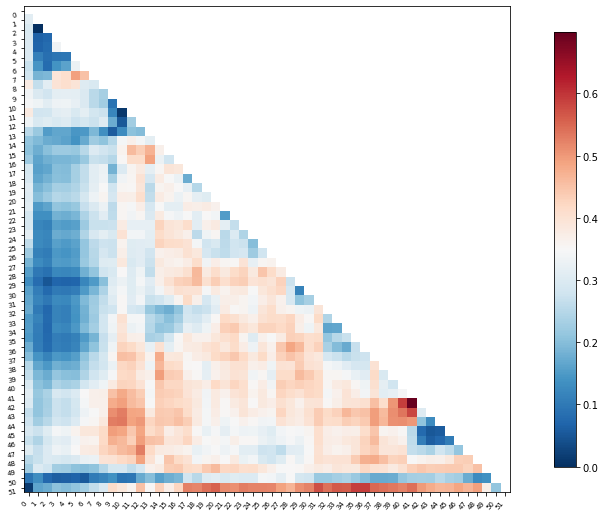

In [9]:
# label_data = pd.read_csv('/data/MBDU/midla/notebooks/campcc/atlas_labels.csv', header=None).values.tolist()
# labels = []
# for x in label_data:
#     labels.append(x[0])
plotting.plot_matrix(fixed_df,labels=labels,tri='lower',figure=(10,10))

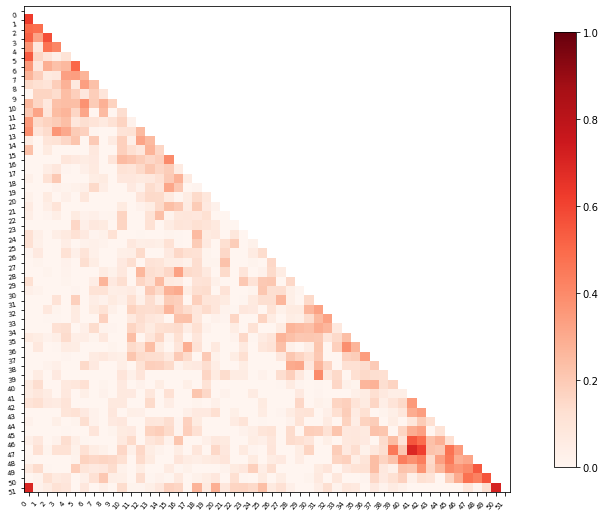

In [28]:
fig,ax = plt.subplots(1,figsize = (10,10))
plotting.plot_matrix(random_df, figure = fig,labels=labels,tri='lower',cmap = 'Reds',vmax = 1)
fig.patch.set_facecolor('white')

In [8]:
row.cfd_path

NameError: name 'row' is not defined